In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [27]:
df = pd.read_csv('/superstore_sales_analysis/cleaned_sales_data.csv')

In [28]:
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,...,Quantity,Discount,Profit,Order Year,Order Month,Order Day,Order Month(N),CLV,Delivery Time (days),Ship Day
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,2,0.00,41.9136,2016,11,Tue,November,3146.243079,3,Fri
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,3,0.00,219.5820,2016,11,Tue,November,3146.243079,3,Fri
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,...,2,0.00,6.8714,2016,6,Sun,June,3066.005363,4,Thu
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,...,5,0.45,-383.0310,2015,10,Sun,October,7127.853161,7,Sun
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,...,2,0.20,2.5164,2015,10,Sun,October,7127.853161,7,Sun


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Order ID              9993 non-null   object 
 1   Order Date            9993 non-null   object 
 2   Ship Date             9993 non-null   object 
 3   Ship Mode             9993 non-null   object 
 4   Customer ID           9993 non-null   object 
 5   Customer Name         9993 non-null   object 
 6   Segment               9993 non-null   object 
 7   Country               9993 non-null   object 
 8   City                  9993 non-null   object 
 9   State                 9993 non-null   object 
 10  Postal Code           9993 non-null   int64  
 11  Region                9993 non-null   object 
 12  Product ID            9993 non-null   object 
 13  Category              9993 non-null   object 
 14  Sub-Category          9993 non-null   object 
 15  Product Name         

In [31]:
df.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
       'Sales', 'Quantity', 'Discount', 'Profit', 'Order Year', 'Order Month',
       'Order Day', 'Order Month(N)', 'CLV', 'Delivery Time (days)',
       'Ship Day'],
      dtype='object')

# Feature Extraction

In [32]:
df['Profit Margin'] = df['Profit']/df['Sales']
df['Discounted Profit'] = df['Profit']-df['Profit']*df['Discount']
df['Discount Percentage'] = df['Discount']/df['Sales']*100
df['Operating Expenses'] = df['Sales'] - df['Profit']
df['Net Profit'] = df['Profit'] - df['Discount']

In [33]:
data_columns = ['Order Date', 'Ship Date']
for col in data_columns:
    df[col] = pd.to_datetime(df[col])

In [35]:
df['Order Weekday'] = df['Order Date'].dt.dayofweek
df['Ship Year'] = df['Ship Date'].dt.year
df['Ship Month'] = df['Ship Date'].dt.month
df['Ship Weekday'] = df['Ship Date'].dt.dayofweek
df.drop(['Order Date','Ship Date'],axis=1,inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Order ID              9993 non-null   object 
 1   Ship Mode             9993 non-null   object 
 2   Customer ID           9993 non-null   object 
 3   Customer Name         9993 non-null   object 
 4   Segment               9993 non-null   object 
 5   Country               9993 non-null   object 
 6   City                  9993 non-null   object 
 7   State                 9993 non-null   object 
 8   Postal Code           9993 non-null   int64  
 9   Region                9993 non-null   object 
 10  Product ID            9993 non-null   object 
 11  Category              9993 non-null   object 
 12  Sub-Category          9993 non-null   object 
 13  Product Name          9993 non-null   object 
 14  Sales                 9993 non-null   float64
 15  Quantity             

In [36]:
df.drop(['Order ID','Customer Name', 'Customer ID'],axis=1,inplace=True)

# Categorical Encoding 

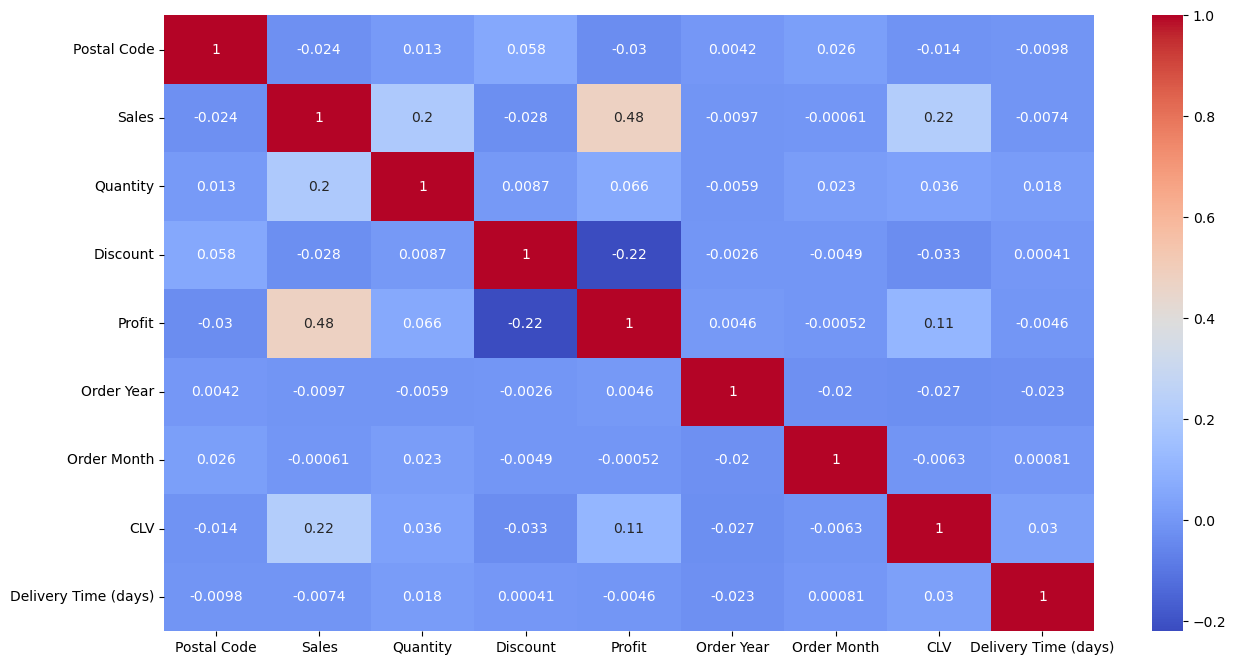

In [6]:
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## Sales 

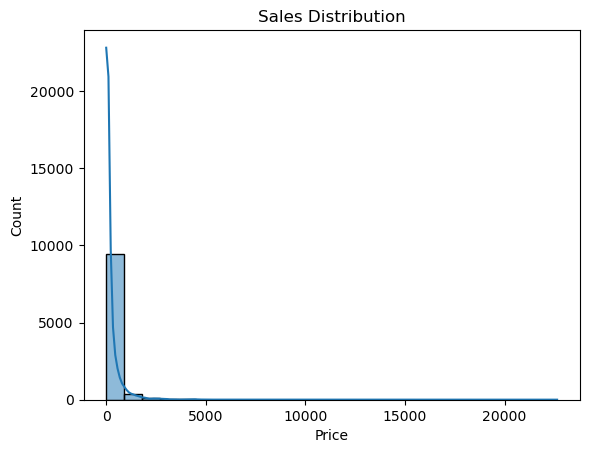

In [19]:
sns.histplot(df["Sales"], bins=25,kde=True)
plt.title("Sales Distribution")
plt.xlabel("Price")
plt.show()

Most of the data points are clustered on the lower end, there are a few extreme values (outliers) on the higher end that significantly pulling the distribution to the right. This is a common characteristics for data like sales, where a small number of customers might make exceptionally large purchases, leading to high values that skew the distribution. 





We are going to apply logarithmic transformation 

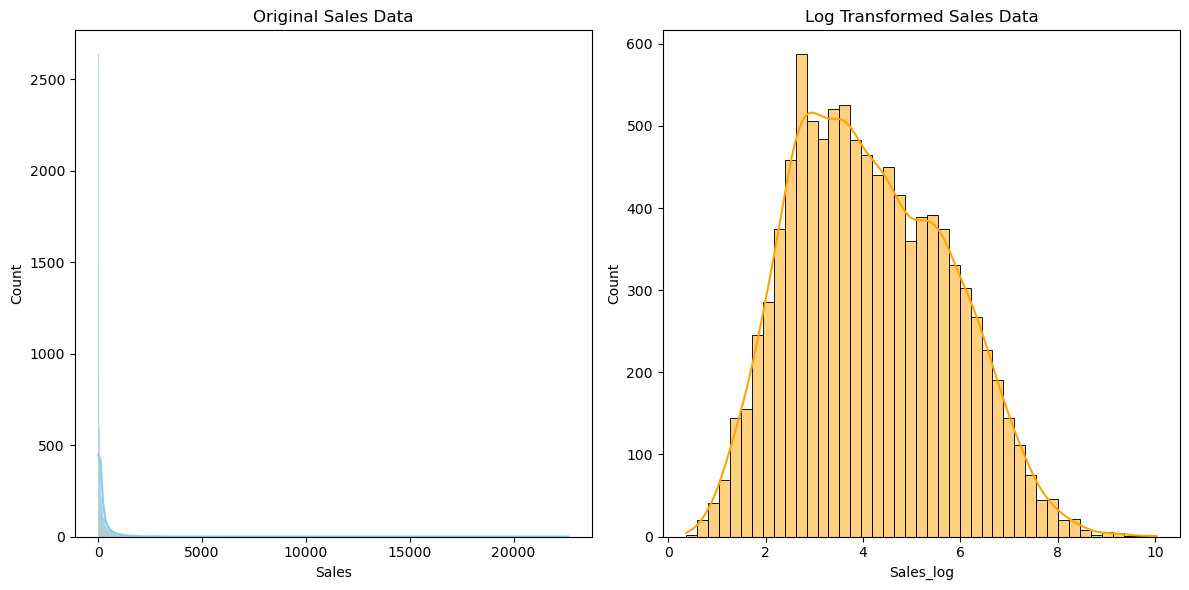

In [23]:
df['Sales_log'] = np.log1p(df['Sales'])

plt.figure(figsize=(12, 6))

# Before transformation
plt.subplot(1, 2, 1)
sns.histplot(df['Sales'], kde=True, color='skyblue')
plt.title('Original Sales Data')

# After transformation
plt.subplot(1, 2, 2)
sns.histplot(df['Sales_log'], kde=True, color='orange')
plt.title('Log Transformed Sales Data')

plt.tight_layout()
plt.show()